# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

In [1]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline 

## 1. Create references to images

### 1.1. References to sample images

In [2]:
sample_images = glob.glob('./test_images/*.jpg')

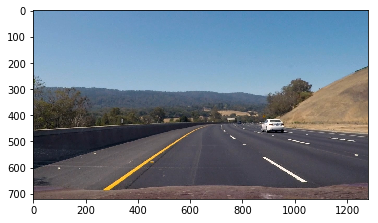

In [3]:
plt.imshow(mpimg.imread(sample_images[2]))

### 1.2  References to labeled training dataset

In [4]:
vehicle_images = glob.glob('./data/vehicles/*/*.png')
non_vehicle_images = glob.glob('./data/non-vehicles/*/*.png')

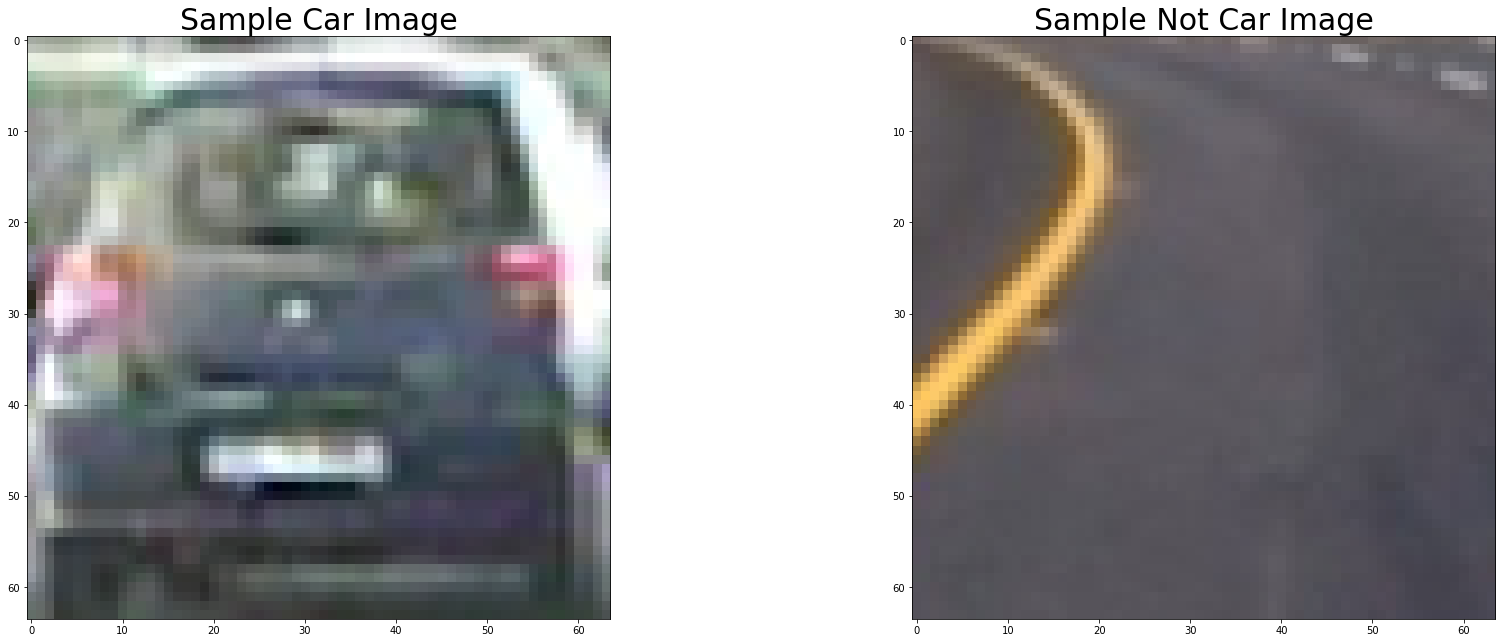

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(vehicle_images[0]))
ax1.set_title("Sample Car Image", fontsize=30)
ax2.imshow(mpimg.imread(non_vehicle_images[0]))
ax2.set_title("Sample Not Car Image", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
combined_vehicle_images = np.hstack((vehicle_images,non_vehicle_images))
y = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

In [7]:
print(len(combined_vehicle_images))

17760


In [8]:
#Please note: I used a subset of the total labeled dataset to reduce memory and compute resource
rand_state = np.random.randint(0, 100)
image_subset, _, y_subset, _ = train_test_split(
    combined_vehicle_images, y, test_size=0.9, random_state=rand_state) 

In [9]:
print(len(image_subset))
print(len(y_subset))

1776
1776


## 2. Create feature extractor

### _This combines Hog, histogram and spatial features_

In [10]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,hist_bins=32,
                         hist_range=(0, 256),spatial_size=(32, 32)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features,hist_features,spatial_features)))
    # Return list of feature vectors
    return features

In [11]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 4
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
histbin = 32
histrange = (0,256)
spatial = 32

(8100,)


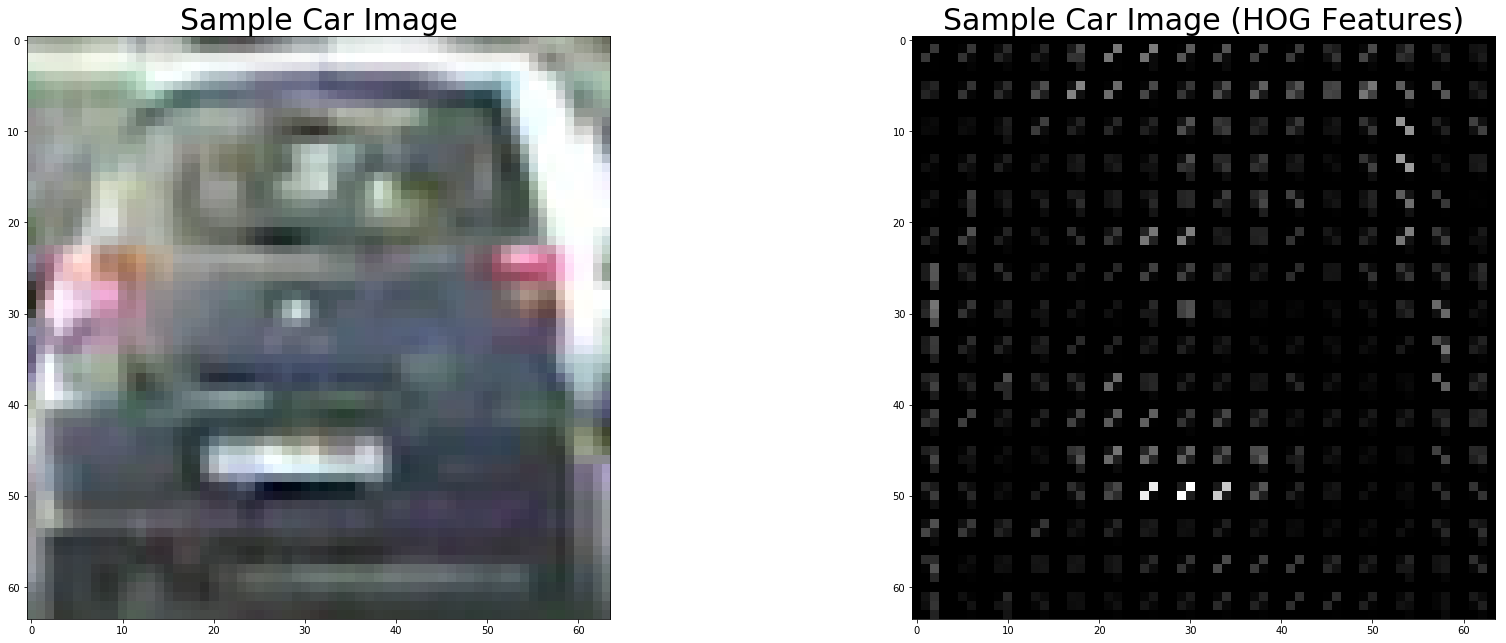

In [12]:
car = mpimg.imread(vehicle_images[0])
feat, car_hog = get_hog_features(car[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
print(feat.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(car)
ax1.set_title("Sample Car Image", fontsize=30)
ax2.imshow(car_hog,cmap='gray')
ax2.set_title("Sample Car Image (HOG Features)", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

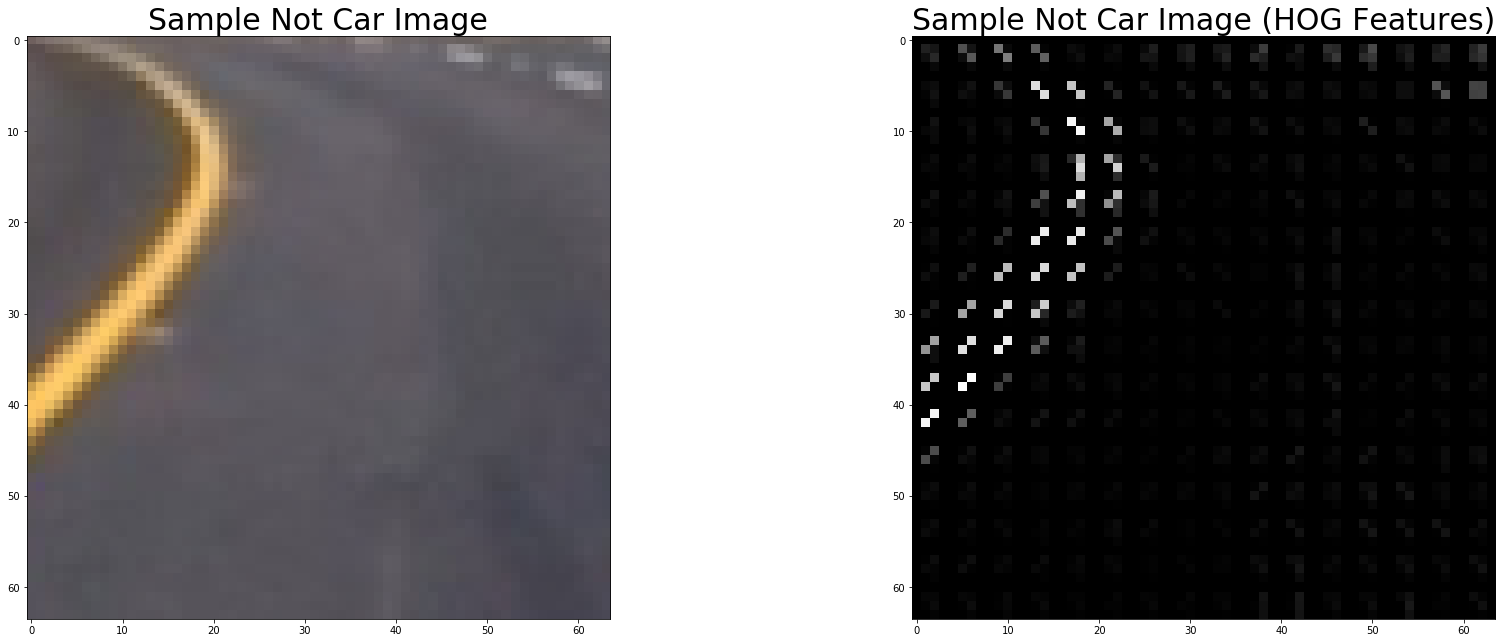

In [13]:
notcar = mpimg.imread(non_vehicle_images[0])
_, notcar_hog = get_hog_features(notcar[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(notcar)
ax1.set_title("Sample Not Car Image", fontsize=30)
ax2.imshow(notcar_hog,cmap='gray')
ax2.set_title("Sample Not Car Image (HOG Features)", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [14]:
import gc
vehicle_images = None
non_vehicle_images = None
combined_vehicle_images = None
car = None
car_hog = None
notcar = None
notcar_hog = None
gc.collect()

8732

In [15]:
X_subset = extract_features(image_subset, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,hist_bins=histbin, hist_range=histrange,
                            spatial_size=(spatial, spatial))

In [16]:
print(X_subset[0].shape)

(27468,)


## 3. Normalize feature set

In [17]:
X_scaler = StandardScaler().fit(X_subset)

In [18]:
scaled_X_subset = X_scaler.transform(X_subset)

## 4. Shuffle and split training dataset

In [19]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X_subset, y_subset, test_size=0.2, random_state=rand_state)

## 5. Train Linear SVM classifier

In [20]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 27468
1.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9972
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  1.]
0.00412 Seconds to predict 10 labels with SVC


## 6. Implement Sliding Windows

In [23]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins,histrange, boxes,get_img=False):
    
    bboxes_set = boxes[:]
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), 
                                                       np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, hist_bins, histrange)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, hist_features,
                                                          spatial_features)).reshape(1, -1))
            
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes_set.append([(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    if(get_img == False):
        return bboxes_set
    else:
        return draw_img

In [43]:
ystart = 400
ystop = 656
scale = 1.5

In [44]:
test_images = [mpimg.imread(image) for image in sample_images]
out_images = [find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, (spatial, spatial),
                               histbin, histrange, [], get_img=True) for test_image in test_images]

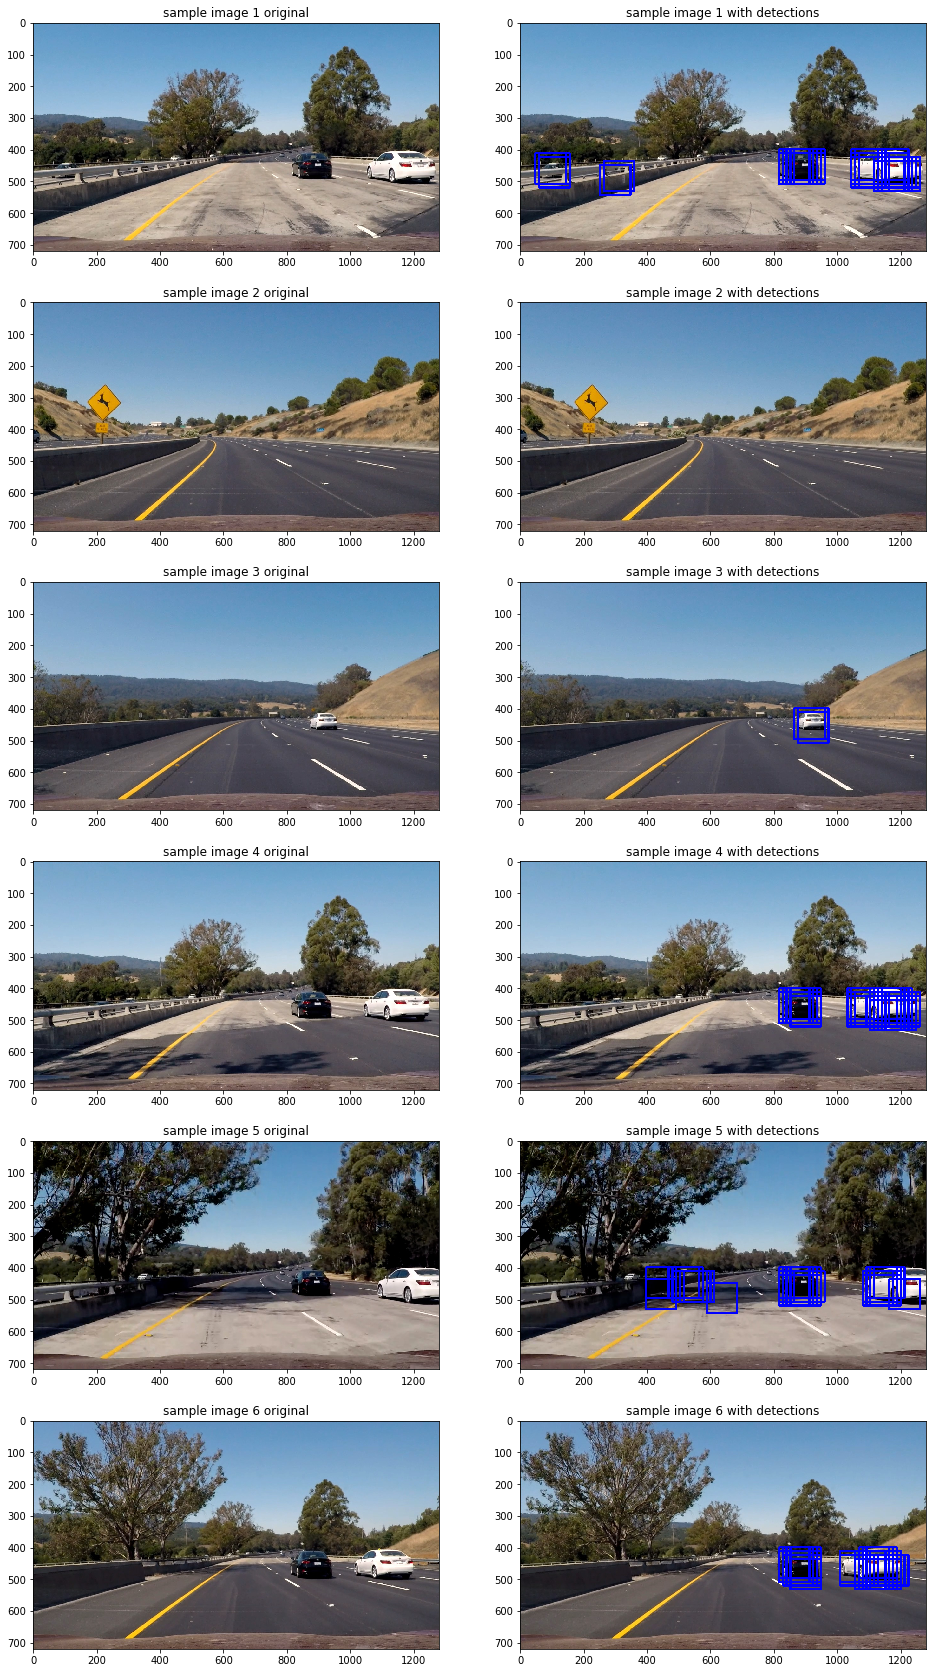

In [45]:
plt.figure(figsize=(16,30))
i = 1
j = 0
for test in test_images:
    plt.subplot(6,2,i)
    plt.title("sample image "+str(j+1)+" original")
    plt.imshow(test_images[j])
    i+=1
    plt.subplot(6,2,i)
    plt.title("sample image "+str(j+1)+" with detections")
    plt.imshow(out_images[j])
    i+=1
    j+=1

## 7. Filter Out False Positives

In [46]:
def multi_scale_find_cars(image, scales):
    bboxes = []
    for scale_number in scales:
        bboxes = find_cars(image, ystart, ystop, scale_number, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, (spatial, spatial),
                               histbin, histrange, bboxes, get_img=False)
    return bboxes
    

In [47]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [48]:
def filter_false_positives(image,box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heat_map = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_map)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_image,heat_map

In [53]:
filtered = [(test_image,filter_false_positives(test_image,multi_scale_find_cars(test_image,[1,1.5,2]))) for test_image in test_images]

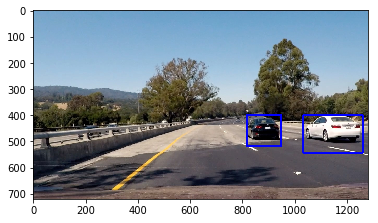

In [59]:
plt.imshow(filtered[3][1][0])

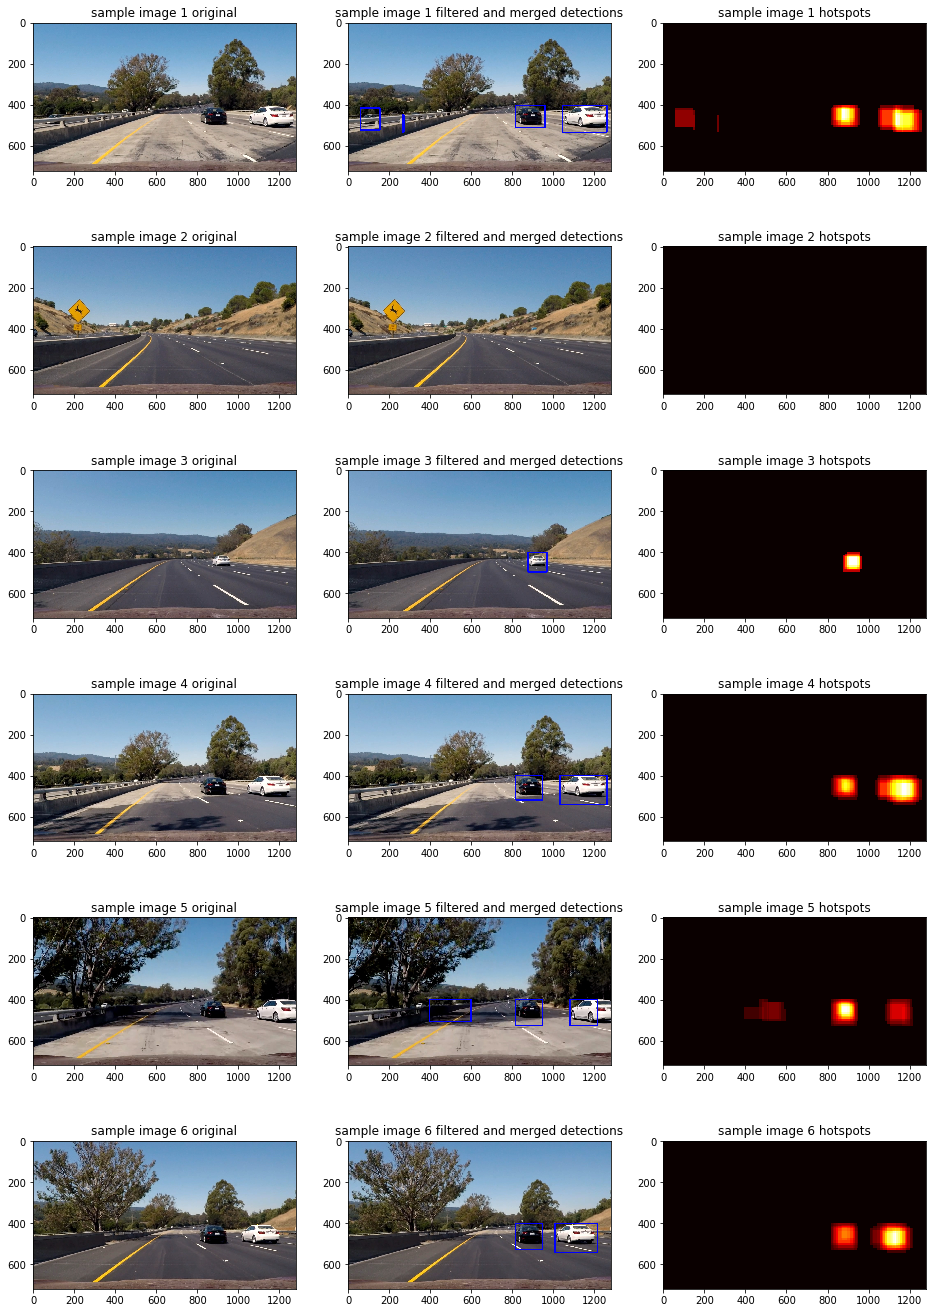

In [63]:
plt.figure(figsize=(16,24))
i = 1
j = 0
for img in filtered:
    plt.subplot(6,3,i)
    plt.title("sample image "+str(j+1)+" original")
    plt.imshow(filtered[j][0])
    i+=1
    plt.subplot(6,3,i)
    plt.title("sample image "+str(j+1)+" filtered and merged detections")
    plt.imshow(filtered[j][1][0])
    i+=1
    plt.subplot(6,3,i)
    plt.title("sample image "+str(j+1)+" hotspots")
    plt.imshow(filtered[j][1][1],cmap='hot')
    i+=1
    j+=1

## 8. Generate Video File

In [69]:
# This function pieces together the individual functions above into an end-to-end pipeline for
# processing the video images

def process_image(image):

    vbox_list = find_cars(image, 400, 500, 1, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, (spatial, spatial),
                               histbin, histrange, [], get_img=False)
    
    vbox_list = find_cars(image, 400, 600, 1.5, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, (spatial, spatial),
                               histbin, histrange, vbox_list, get_img=False)
    
    vbox_list = find_cars(image, 500, 650, 2, svc, X_scaler, orient,
                               pix_per_cell, cell_per_block, (spatial, spatial),
                               histbin, histrange, vbox_list, get_img=False)
    
        
    result,_ = filter_false_positives(image,vbox_list)
     
    return result

In [70]:
# importing the libraries needed for the video processing
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [71]:
import gc
vehicle_images = None
non_vehicle_images = None
combined_vehicle_images = None
image_subset = None
y_subset = None
car = None
car_hog = None
notcar = None
notcar_hog = None
X_train = None
X_test = None
y_train = None
y_test = None
test_image = None
gc.collect()

0

In [74]:
# processing the project video

test_video1 = './output_images/my_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_video1_clip = clip1.fl_image(process_image) 
%time test_video1_clip.write_videofile(test_video1, audio=False)

[MoviePy] >>>> Building video ./output_images/my_project_video.mp4
[MoviePy] Writing video ./output_images/my_project_video.mp4


100%|█████████▉| 1260/1261 [38:37<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/my_project_video.mp4 

CPU times: user 38min 12s, sys: 6.78 s, total: 38min 18s
Wall time: 38min 39s


In [75]:
# displaying the video processing results
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video1))